# Verifiaction of acoustic modeling with the MMS method

We verify the accuracy and convergence of our finite-difference acoustic modeling kernel in an heterogeneous belocity model with the MMS method

# Seismic modelling with devito

We describe here a step by step setup of seismic modelling with Devito in a simple 2D case. We will create a physical model of our domain and define a single source and an according set of receivers to model for the forward model. But first, we initialize some basic utilities.

In [1]:
from devito import *

In [2]:
import numpy as np
%matplotlib inline

In [3]:
from examples.seismic import Model
# Model with fixed time step value
class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking.
    The critical dt is made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value."""
        return .1*self.spacing[0]

In [4]:
# Discretization order
orders = (2, 4, 6, 8, 10)
norder = len(orders)

# Domain sizes and gird spacing
shapes = ((201, 2.0), (161, 2.5), (101, 4.0))
dx = [2.0, 2.5, 4.0]
nshapes = len(shapes)

# Number of time steps
nt = 1501
# Time axis
time = np.linspace(0., 150., nt)
# Source peak frequency
f0 = .07

# Make a three layers velocity model

In [5]:
v = 1.5 * np.ones((201, 201))
v[:, 75:] = 2.5
v[:, 125:] = 3.0
model = ModelBench(vp=v, origin=(0., 0.), spacing=(.005, .005), shape=(201, 201), nbpml=0, space_order=0, dtype=np.float64)

Operator `initdamp` generated in 0.14 s
  * lowering.Expressions: 0.04 s (30.2 %)
  * specializing.IET: 0.03 s (22.7 %)
Allocating memory for damp(243, 243)
Operator `initdamp` jit-compiled `/var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-jitcache-uid501/f749727b100b77ebe4a2c98370fbbc03e58f82d7.c` in 7.55 s with `IntelCompiler`
Operator `initdamp` run in 0.01 s
* section0<<20,241>,<20,241>,<241,20>,<241,20>> with OI=0.01 computed in 0.01 s [0.06 GFlops/s]
Configuration:  {'dse': 'noop', 'dle': 'advanced'}
Performance arguments:  {'nthreads': 2}
Allocating memory for vp(241, 241)
Operator `padfunc` generated in 0.28 s
  * specializing.IET: 0.08 s (28.7 %)
  * lowering.Expressions: 0.08 s (28.7 %)
Flops reduction after symbolic optimization: [0 --> 0 ; 0 --> 0 ; 0 --> 0 ; 0 --> 0]
Operator `padfunc` jit-compiled `/var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-jitcache-uid501/a4b913b33eefc8e4203745d4e477069ed05d839f.c` in 9.96 s with `IntelCompiler`
Operator `padfunc` run

# Analytical solution definition

In [6]:
x, z = model.grid.dimensions
t = model.grid.time_dim

In [7]:
from sympy import cos, sin, exp, pprint, sqrt, sin, sinc

In [8]:
# sol = sin(2*np.pi*t.spacing*t/10)* exp(-(x.spacing*x - 100)**2/200 - (z.spacing*z - 100)**2/200)
import sympy
u, v, w, c = sympy.symbols('u v w c')
sol = sin(2*np.pi*u) * sin(4*np.pi*v)* sin(2*np.pi*w)

# Corresponding source

In [9]:
source =  model.m*sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)

In [10]:
sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
source = source.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})

# Wave equation

In [11]:
u = TimeFunction(name="u", grid=model.grid, space_order=16, time_order=2)
u_true = TimeFunction(name="utrue", grid=model.grid, space_order=0, time_order=2)
src = TimeFunction(name="src", grid=model.grid, space_order=0, time_order=2)

In [12]:
wave_eq = Eq(u.forward, 2 * u - u.backward + t.spacing**2/model.m * (u.laplace + src))

In [13]:
true_eqq = Eq(u_true, sol)

In [14]:
src_eq = Eq(src, source)

In [15]:
# inital conditions, t=1
u_1 = Eq(u.subs(t, 1), sol.subs(t, 1))

In [17]:
## from devito import configuration
configuration["log-level"] = "ERROR"
h = .00125
op = Operator([u_1, true_eqq, src_eq, wave_eq], subs=({t.spacing: .1*h, x.spacing:h, z.spacing:h}))
op.apply(t_m=1, t_M=100)

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.038957999999999986, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [18]:
def mms_sol(model):
    u, v, w, c = sympy.symbols('u v w c')
    sol = (1e4*sin(6*np.pi*w) * exp(-(u - .5)**2/.015 - (v-.5)**2/.015) -
           1e3*sin(4*np.pi*w) *exp(-(u - .45)**2/.0025 - (v-.65)**2/.0025)-
           5000*sin(8*np.pi*w) *exp(-(u - .65)**2/.0025 - (v-.45)**2/.0015)+
           1e4*sin(6*np.pi*w) * exp(-(u - .45)**2/.0015 - (v-.45)**2/.0025)-
           5*1e3*sin(6*np.pi*w) * exp(-(u - .65)**2/.0027 - (v-.65)**2/.0021))
    source =  model.m*sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
    x, z = model.grid.dimensions
    t = model.grid.time_dim
    
    sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
    source = source.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
    
    return sol, source

In [21]:
def get_solution(size, space_order):
    clear_cache()
    # Model
    v = 1.5 * np.ones((size, size))
    v[:, 75:] = 2.5
    v[:, 125:] = 3.0
    model = ModelBench(vp=v, origin=(0., 0.), spacing=(1., 1.), shape=(size, size),
                       nbpml=0, space_order=0, dtype=np.float64)
    x, z = model.grid.dimensions
    t = model.grid.time_dim
    # Grid
    h = 1./(size - 1)
    dt = 1e-7
    nt = 350
    # Wave equation
    u = TimeFunction(name="u", grid=model.grid, space_order=space_order, time_order=2, save=nt)
    u_true = TimeFunction(name="utrue", grid=model.grid, space_order=space_order, time_order=0, save=nt)
    src = TimeFunction(name="src", grid=model.grid, space_order=space_order, time_order=0, save=nt)

    sol, source = mms_sol(model)
    
    wave_eq = Eq(u.forward, 2 * u - u.backward + t.spacing**2/model.m * (u.laplace + src))
    true_eqq = Eq(u_true, sol)

    src_eq = Eq(src, source)
    
    u_1 = Eq(u.subs(t, 1), sol.subs(t, 1))
    configuration["log-level"] = "ERROR"
    op = Operator([u_1, true_eqq, src_eq, wave_eq], subs=({t.spacing: dt, x.spacing:h, z.spacing:h}))
    op.apply()

    error = np.linalg.norm(u.data[(nt-3), :, :].reshape(-1) -
                           u_true.data[(nt-3), :, :].reshape(-1), 2)*h
    print("for h = %f and dt= %2.2e ms error is %2.4e" % (h, dt, error))
    return error

# MMS

In [22]:
size = [26, 51, 101, 201]
t = 2
so = [2, 4, 6, 8, 10]
error = np.zeros((4, 5))
hh = [0.04, 0.02, 0.01, 0.005]
# hh = [1, .5, .25, .125]
# hh = [4*h for h in hh]
for i, s in enumerate(size):
    for j, sso in enumerate(so):
        error[i, j] = get_solution(s, sso)

for h = 0.040000 and dt= 1.00e-07 ms error is 1.0279e-07
for h = 0.040000 and dt= 1.00e-07 ms error is 6.6287e-08
for h = 0.040000 and dt= 1.00e-07 ms error is 5.3194e-08
for h = 0.040000 and dt= 1.00e-07 ms error is 4.6730e-08
for h = 0.040000 and dt= 1.00e-07 ms error is 4.2943e-08
for h = 0.020000 and dt= 1.00e-07 ms error is 3.1249e-08
for h = 0.020000 and dt= 1.00e-07 ms error is 8.2700e-09
for h = 0.020000 and dt= 1.00e-07 ms error is 3.3799e-09
for h = 0.020000 and dt= 1.00e-07 ms error is 1.7486e-09
for h = 0.020000 and dt= 1.00e-07 ms error is 1.0477e-09
for h = 0.010000 and dt= 1.00e-07 ms error is 8.2377e-09
for h = 0.010000 and dt= 1.00e-07 ms error is 6.3760e-10
for h = 0.010000 and dt= 1.00e-07 ms error is 8.4384e-11
for h = 0.010000 and dt= 1.00e-07 ms error is 1.5519e-11
for h = 0.010000 and dt= 1.00e-07 ms error is 3.6031e-12
for h = 0.005000 and dt= 1.00e-07 ms error is 3.2592e-09
for h = 0.005000 and dt= 1.00e-07 ms error is 6.6378e-11
for h = 0.005000 and dt= 1.00e-

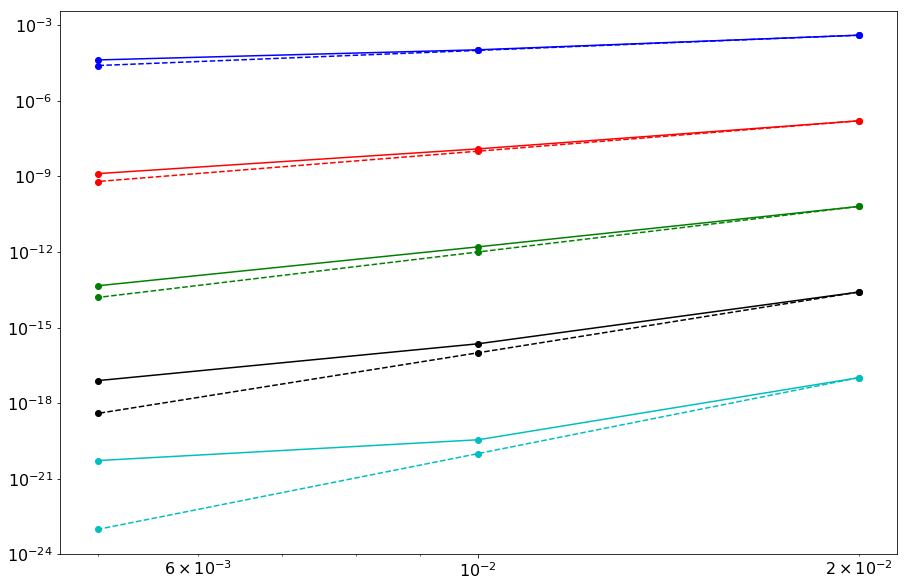

In [24]:
import matplotlib.pyplot as plt
col = ['-ob', '-or', '-og', '-ok', '-oc']
col_2 = ['--ob', '--or', '--og', '--ok', '--oc']
hh = [0.04, 0.02, 0.01, 0.005]
plt.figure(figsize=(15, 10))
for j, sso in enumerate(so):
    plt.loglog(hh[1:4], hh[1]**so[j]*error[1:4, j]/error[1, j], col[j])
    plt.loglog(hh[1:4], [h**so[j] for h in hh][1:4], col_2[j])

# plt.loglog(hh, error[:, 3])
# plt.loglog(hh, [h**so[3] for h in hh])